In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

## Read in samples for origin ARS305 to set up the annotation of the nucleosome areas

## Wildtype

In [2]:
load_dir =  "ARS305"

In [3]:
ARS305_wt = np.loadtxt("ARS305/wt_mat_Megalodon_repIII_ARS305_end_LexA.txt")
ARS305_wt_rep2 = np.genfromtxt("ARS305/ARS305_wt_REP2_noNA.csv", dtype = int, delimiter = ",") #715 reads

In [4]:
ARS305_wt.shape

(780, 1084)

## Divide the locus into a number of windows with fixed sizes to test for differences in methylation levels

In [5]:
windowsize = 30

d = {"pos_start":list(range(0, ARS305_wt.shape[1], windowsize)),
            "pos_stop":list(range((windowsize -1) , ARS305_wt.shape[1], windowsize)) + [ARS305_wt.shape[1]]}
ARS305_anno = pd.DataFrame(d,
            index = list(range(1, ARS305_wt.shape[1]//windowsize + 2)))
ARS305_anno["length"] = (ARS305_anno.pos_stop +1) - ARS305_anno.pos_start

ARS305_anno["position"] = "x"

ARS305_anno.head()

,pos_start,pos_stop,length,position
1,0,29,30,x
2,30,59,30,x
3,60,89,30,x
4,90,119,30,x
5,120,149,30,x


In [6]:
#load data for mutants:
ARS305_dies6_rep1 = np.loadtxt("ARS305/DIES6_ALL_REP1_ARS305_end_LexA.txt")
ARS305_dies6_rep2 = np.genfromtxt("ARS305/DIES6_ARS305_REP2_780READS.csv", dtype = int, delimiter = ",")

ARS305_disw2_rep1 = np.genfromtxt("ARS305/ARS305_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
ARS305_disw2_rep2 = np.genfromtxt("ARS305/ARS305_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")

In [7]:
#load data for reverse strands:

wt_rep3_rev = np.loadtxt( load_dir + "/wt_repIII_ARS305_end_LexA_minus.txt") #780 reads
wt_rep2_rev = np.loadtxt( load_dir + "/wt_repII_ARS305_minus.txt") #780 reads

dies6_rep1_rev = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS305_minus.txt") #780 reads
dies6_rep2_rev = np.loadtxt(load_dir + "/DIES6_ALLstrains_meth_REP2_ARS305_minus.txt") #780 reds

disw2_rep1_rev = np.loadtxt(load_dir + "/REP1_disw2_ARS305_minus.txt") 
disw2_rep2_rev = np.loadtxt(load_dir + "/disw2_all_meth_REP2_ARS305_minus.txt") #780 reads

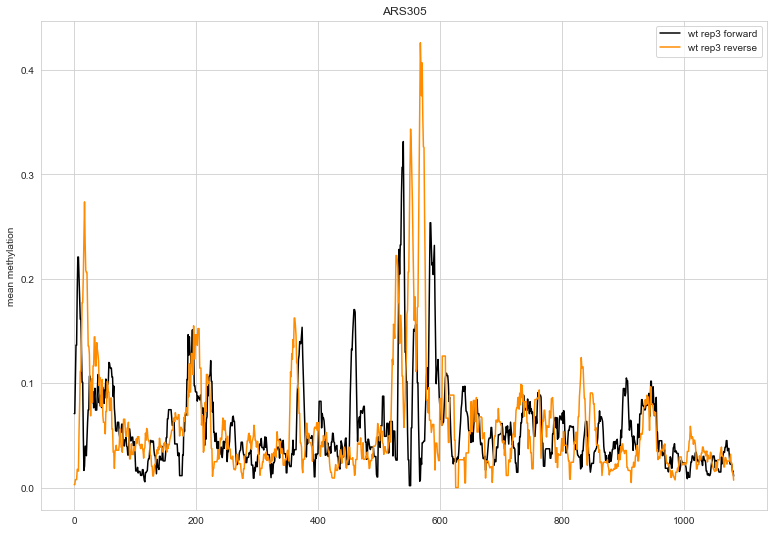

In [8]:
N=10

plt.figure(figsize=(13, 9))
sns.lineplot(x = range(1083), y = np.convolve(ARS305_wt.mean(axis=0)[1:], np.ones(N)/N, mode ="same")
             , color ="black", label="wt rep3 forward")
sns.lineplot(x = range(1083), y = np.convolve(wt_rep3_rev.mean(axis=0), np.ones(N)/N, mode ="same"), 
             color ="darkorange", label="wt rep3 reverse")
plt.ylabel("mean methylation")
plt.title("ARS305")
plt.show()

## Join the matrices for forward and reverse strand

In [9]:
wt_rep3_join = np.concatenate((ARS305_wt[:, 1:], wt_rep3_rev), axis = 0)

In [10]:
def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

#subsample dies6_rep2_rev to 715 reads
wt_rep2_rev_sub = subsample(wt_rep2_rev, 715)
wt_rep2_join = np.concatenate((ARS305_wt_rep2[:, 1:], wt_rep2_rev_sub), axis = 0)

dies6_rep1_join = np.concatenate((ARS305_dies6_rep1[:, 1:], dies6_rep1_rev), axis = 0)
dies6_rep2_join = np.concatenate((ARS305_dies6_rep2[:, 1:], dies6_rep2_rev), axis = 0)

disw2_rep1_join = np.concatenate((ARS305_disw2_rep1[:, 1:], disw2_rep1_rev), axis = 0)
disw2_rep2_join = np.concatenate((ARS305_disw2_rep2[:, 1:], disw2_rep2_rev), axis = 0)

In [11]:
#summarise samples
array_dic = {"wt_rep3": wt_rep3_join, 
             "wt_rep2": wt_rep2_join, 
             "dies6_rep1": dies6_rep1_join,
            "dies6_rep2": dies6_rep2_join,
            "disw2_rep1": disw2_rep1_join,
            "disw2_rep2": disw2_rep2_join}

summary=pd.DataFrame()
for element in array_dic.keys():
    summary[element] = pd.DataFrame(array_dic[element].mean(axis=0)).describe()
summary = summary.T
summary["#molecules"] = [array_dic[sample].shape[0] for sample in summary.index]
#summary = summary.T
summary

,count,mean,std,min,25%,50%,75%,max,#molecules
wt_rep3,1083.0,0.057034,0.070619,0.0,0.001923,0.035897,0.080128,0.450000,1560
wt_rep2,1083.0,0.044079,0.056571,0.0,0.000699,0.025874,0.060839,0.369231,1430
dies6_rep1,1083.0,0.073741,0.093714,0.0,0.001282,0.045513,0.107051,0.587821,1560
dies6_rep2,1083.0,0.065112,0.089025,0.0,0.000641,0.037179,0.087821,0.579487,1560
disw2_rep1,1083.0,0.090573,0.111351,0.0,0.000641,0.058974,0.138782,0.687179,1560
disw2_rep2,1083.0,0.090745,0.112197,0.0,0.001923,0.056410,0.135897,0.713462,1560


In [12]:
#assign the old variable names for a quick check for the effects of the reverse strand

ARS305_wt = wt_rep3_join
ARS305_wt_rep2 = wt_rep2_join

ARS305_dies6_rep1 = dies6_rep1_join
ARS305_dies6_rep2 = dies6_rep2_join

ARS305_disw2_rep1 = disw2_rep1_join
ARS305_disw2_rep2 = disw2_rep2_join

### Normalise each experiment to the methylation level of the spike-in control and pool replicates

In [13]:
#normalisation to the mean methylation freq of the spike in of nucleosomal arrays
mean_array_wt_rep3 = 0.048283
mean_array_wt_rep2 = 0.034160
mean_array_dies6_rep1=0.050732
mean_array_dies6_rep2 = 0.045048
mean_array_disw2_rep1 = 0.061350
mean_array_disw2_rep2 = 0.059359

wt_rep3_minmax = ARS305_wt.mean(axis = 0)/mean_array_wt_rep3
wt_rep2_minmax = ARS305_wt_rep2.mean(axis = 0)/mean_array_wt_rep2

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = ARS305_dies6_rep1.mean(axis = 0)/mean_array_dies6_rep1
dies6_rep2_minmax = ARS305_dies6_rep2.mean(axis = 0)/mean_array_dies6_rep2

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = ARS305_disw2_rep1.mean(axis = 0)/mean_array_disw2_rep1
disw2_rep2_minmax = ARS305_disw2_rep2.mean(axis = 0)/mean_array_disw2_rep2

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)



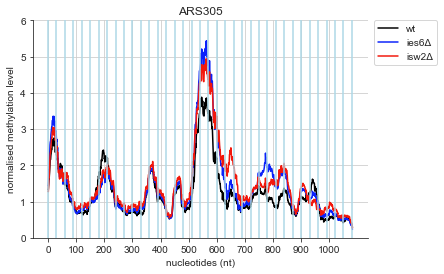

In [14]:
N=30

with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        for left_border in ARS305_anno.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS305_smoothed_profiles_wt_mut_revision.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

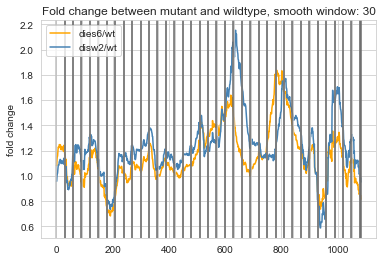

In [15]:
N=30
sns.lineplot(x = range(pooled_wt.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "orange", 
             label = "dies6/wt")
sns.lineplot(x = range(pooled_wt.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "steelblue",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype, smooth window: " + str(N))
for border in ARS305_anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in ARS305_anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")

### Compare mean distributions between pooled replicates and wildtype with paired wilcoxon test

In [16]:
segments = ARS305_anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [pooled_dies6[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["dies6_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [pooled_disw2[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["disw2_mean"] = pd.Series(array_list, index = segments.index)

In [17]:
segments["p_value_dies6"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments.drop(segments.columns[3:6], axis =1, inplace = True)

In [18]:
segments
#segments.to_csv(load_dir + "/ARS305_pooled_samples_two-sided-test.csv")

,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
1,0,29,30,0.008685,0.027306
2,30,59,30,0.986134,0.715145
3,60,89,30,0.123045,0.036257
4,90,119,30,0.637818,0.177876
5,120,149,30,0.022809,0.017270
6,150,179,30,0.569934,0.445498
7,180,209,30,0.005111,0.018675
8,210,239,30,0.177876,0.026155
9,240,269,30,0.543016,0.149178
10,270,299,30,0.100506,0.001405


In [19]:
#Regions significant for dies6 and disw2:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation mutants compared to wildtype?")
print("       P-value below: ", pvalue)
significant = segments.loc[(segments["p_value_dies6"] < pvalue) | (segments["p_value_disw2"] < pvalue)]
significant

       Which sites have a different mean methylation mutants compared to wildtype?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
1,0,29,30,0.008685,0.027306
5,120,149,30,0.022809,0.017270
7,180,209,30,0.005111,0.018675
10,270,299,30,0.100506,0.001405
11,300,329,30,0.026399,0.000295
12,330,359,30,0.223757,0.000588
13,360,389,30,0.011867,0.010817
16,450,479,30,0.008146,0.000091
17,480,509,30,0.055347,0.005644
18,510,539,30,0.000127,0.000233


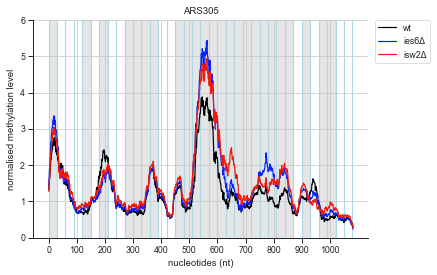

In [20]:
N=30
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        for left_border in ARS305_anno.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        for feature in significant.index:
            plt.fill_betweenx(range(0,7), 
                      significant.loc[feature, "pos_start"],
                      significant.loc[feature, "pos_stop"], 
                      color = "silver", alpha = 0.4)
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS305_smoothed_profiles_revision_window30_union_selection.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

### Use peak detection to characterise peaks of the entire origin

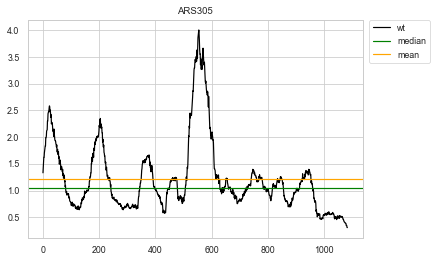

In [21]:
N=40
pooled_wt_smoothed = np.convolve(pooled_wt, np.ones(N)/N, mode="same")

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = pooled_wt_smoothed, color = "black", label = "wt")
plt.axhline(np.median(pooled_wt_smoothed,axis=0), color ="green", label = "median")
plt.axhline(np.mean(pooled_wt_smoothed,axis=0), color ="orange", label = "mean")
plt.title(load_dir)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0,
          labels = ["wt", "median", "mean"])

In [22]:
from scipy import signal

x = pooled_wt_smoothed#[580:820]
peaks, properties = signal.find_peaks(x, width=20, 
                               rel_height=0.9,
                               #prominence = (None, 0.8), 
                               height= np.median(x)
                              )
properties

{'peak_heights': array([2.58406913, 2.34893968, 1.66658906, 1.24803231, 4.00516571,
        1.23264794, 1.39680862, 1.26069953, 1.39656548]),
 'prominences': array([1.25226166, 1.70826536, 1.02671236, 0.48995695, 3.42908848,
        0.29402312, 0.6429764 , 0.45196183, 0.70661857]),
 'left_bases': array([  0, 129, 285, 432, 432, 635, 691, 810, 878]),
 'right_bases': array([ 432,  432,  432,  495, 1082,  691, 1082,  878, 1082]),
 'widths': array([ 61.60151635, 118.85840981,  82.78645101,  54.44338971,
        175.22166833,  30.68949706, 105.1343583 ,  47.95370677,
         86.28812728]),
 'width_heights': array([1.45703364, 0.81150085, 0.74254794, 0.80707106, 0.91898608,
        0.96802712, 0.81812986, 0.85393388, 0.76060876]),
 'left_ips': array([  1.13802915, 139.04306786, 338.07481768, 438.25162229,
        504.15619824, 639.01770762, 704.69096008, 810.91430813,
        883.47541983]),
 'right_ips': array([ 62.73954549, 257.90147768, 420.86126868, 492.695012  ,
        679.37786657, 6

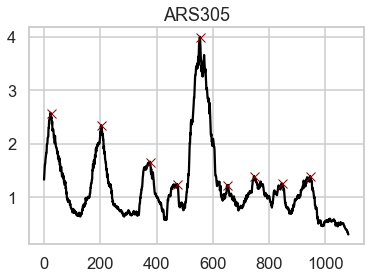

In [23]:
sns.set_context("talk")

plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "darkred")
#plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
#            xmax=properties["right_ips"], color = "darkred")

#plt.text(x = properties["left_ips"],y=properties["width_heights"], s = ("width: " + str(int(properties["widths"]))),
#         fontsize = 13, color="darkred")
plt.title(load_dir)
plt.show()

In [24]:
print(properties["peak_heights"].mean(axis=0))
print(properties["prominences"].mean(axis=0))

1.904390828126162
1.1113183040125556


## Compare average methylation per feature

In [25]:
#Display the mean methylation per feature

def condense_features(array, anno):
    output = np.empty(array.shape[0],)
    for index in anno.index:
        feature_array = array[:, anno.loc[index, "pos_start"]: anno.loc[index, "pos_stop"]]
        means_by_feature = np.apply_along_axis(np.mean, 1, feature_array)
        #means_by_feature = np.apply_along_axis(np.std, 1, feature_array)**2 #to calculate variance
        output = np.column_stack((output, means_by_feature))
    return output[:, 1:]

def max_normalise_array(array):
    return array/array.mean(axis=0).max()

In [26]:
#for the fixed window size approach, only select significantly different regions
saved = ARS305_anno.copy()
ARS305_anno = ARS305_anno.iloc[(ARS305_anno.index.intersection(significant.index)-1),:]

In [27]:
#normalise the count matrices to the mean methylation frequency of the nucleosomal array spike-in controls
#normalise to the nucleosomal array spike-ins

wt_rep3_maxnorm = ARS305_wt/mean_array_wt_rep3
wt_rep2_maxnorm = ARS305_wt_rep2/mean_array_wt_rep2

dies6_rep1_maxnorm = ARS305_dies6_rep1/mean_array_dies6_rep1
dies6_rep2_maxnorm = ARS305_dies6_rep2/mean_array_dies6_rep2

disw2_rep1_maxnorm = ARS305_disw2_rep1/mean_array_disw2_rep1
disw2_rep2_maxnorm = ARS305_disw2_rep2/mean_array_disw2_rep2

#condense methylation by feature

wt_rep3_feat_me = condense_features(wt_rep3_maxnorm, ARS305_anno)
wt_rep2_feat_me = condense_features(wt_rep2_maxnorm, ARS305_anno)
wt_pool = np.concatenate((wt_rep3_feat_me, wt_rep2_feat_me), axis = 0)

dies6_rep1_feat_me = condense_features(dies6_rep1_maxnorm, ARS305_anno)
dies6_rep2_feat_me = condense_features(dies6_rep2_maxnorm, ARS305_anno)
dies6_pool = np.concatenate((dies6_rep1_feat_me, dies6_rep2_feat_me), axis= 0)

disw2_rep1_feat_me = condense_features(disw2_rep1_maxnorm, ARS305_anno)
disw2_rep2_feat_me = condense_features(disw2_rep2_maxnorm, ARS305_anno)
disw2_pool = np.concatenate((disw2_rep1_feat_me, disw2_rep2_feat_me), axis = 0)

Comparing replicates


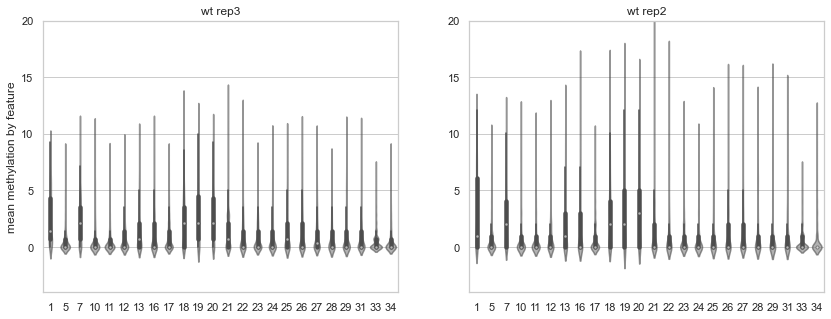

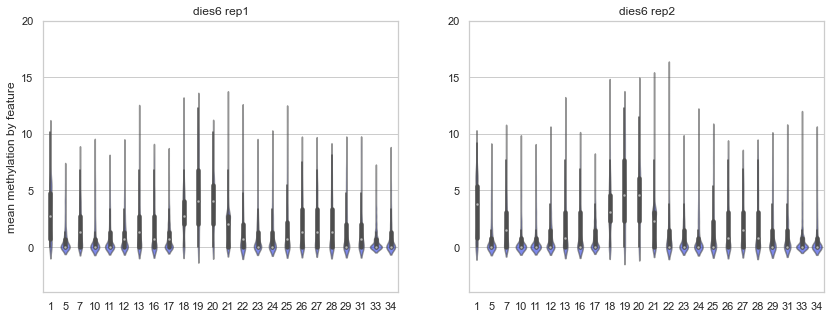

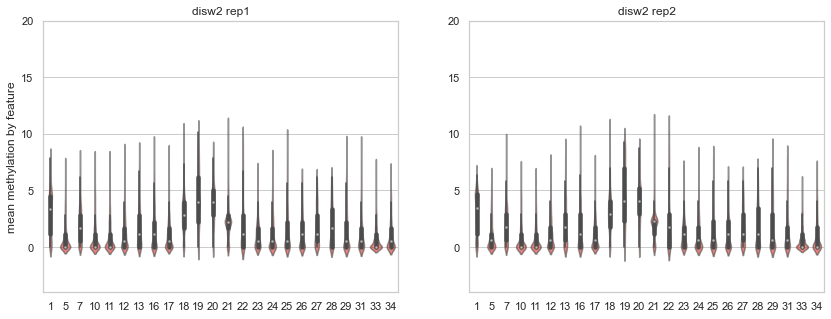

In [28]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

print("Comparing replicates")
#wt
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))

sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "grey", ax=ax1)
ax1.set_title("wt rep3")
ax1.set_xticklabels(ARS305_anno.index)
ax1.set_ylim(-4, 20)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "grey", ax=ax2)
ax2.set_title("wt rep2")
ax2.set_xticklabels(ARS305_anno.index)
ax2.set_ylim(-4, 20)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS305_methylation_by_feature_wt_revision.tif")
plt.show()

#dies6
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "#0a22fa", ax=ax1)
ax1.set_title("dies6 rep1")
ax1.set_xticklabels(ARS305_anno.index)
ax1.set_ylim(-4, 20)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa", ax=ax2)
ax2.set_title("dies6 rep2")
ax2.set_xticklabels(ARS305_anno.index)
ax2.set_ylim(-4, 20)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS305_methylation_by_feature_dies6_revision.tif")
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(ARS305_anno.index)
ax1.set_ylim(-4, 20)
plt.setp(ax1.collections, alpha = 0.6)
ax1.set_ylabel("mean methylation by feature")
#plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(ARS305_anno.index)
ax2.set_ylim(-4, 20)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS305_methylation_by_feature_disw2_revision.tif")
plt.show()

In [29]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = ARS305_anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt rep3"

feat_me_wt_pool = pd.DataFrame(wt_pool, columns = ARS305_anno.index)
feat_me_wt_pool["molecule"] = feat_me_wt_pool.index
feat_me_wt_melt = pd.melt(feat_me_wt_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_melt["condition"] = "wt"


#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = ARS305_anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index

feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "ies6Δ"

feat_me_dies6_pool = pd.DataFrame(dies6_pool, columns = ARS305_anno.index)
feat_me_dies6_pool["molecule"] = feat_me_dies6_pool.index
feat_me_dies6_melt = pd.melt(feat_me_dies6_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_melt["condition"] = "ies6Δ"

#the same for disw2
feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = ARS305_anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index

feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "isw2Δ"

feat_me_disw2_pool = pd.DataFrame(disw2_pool, columns = ARS305_anno.index)
feat_me_disw2_pool["molecule"] = feat_me_disw2_pool.index
feat_me_disw2_melt = pd.melt(feat_me_disw2_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_melt["condition"] = "isw2Δ"

#merge into one dataframe:
methylation_rep1 = pd.concat([feat_me_wt_melt, feat_me_dies6_melt, feat_me_disw2_melt])
methylation_rep1.rename(columns = {"value" : "norm methylation"}, inplace=True)

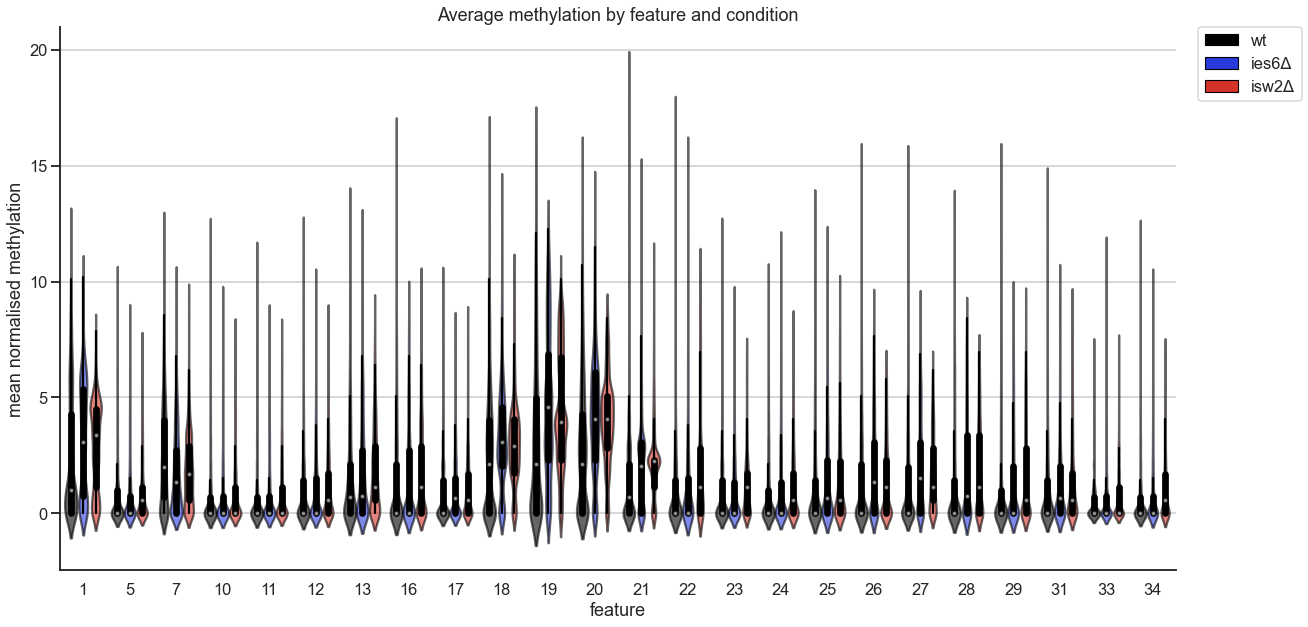

In [30]:
col_Anna = ["black", "#0a22fa", "#f2180c"]

with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False,
                                 'xtick.bottom': False}):
    sns.set_context("talk")
    plt.figure(figsize = (20, 10))#(10,7))
    ax = sns.violinplot(data = methylation_rep1, x="feature", y = "norm methylation", hue = "condition", 
                    palette = col_Anna)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.setp(ax.collections, alpha = 0.6)
    plt.title("Average methylation by feature and condition")
    plt.ylabel("mean normalised methylation")
    #plt.savefig(load_dir + "/plots/ARS305_pooled_norm_av_methylation_by_feature_window30_union_revision.svg", 
     #           dpi = 300, bbox_inches = "tight")
    plt.show()

In [31]:
#methylation_rep1.to_csv(load_dir + "/ARS305_violinplots_annotation_v3.csv")

In [32]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = ARS305_anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3["strand"] = ["plus" if i<feat_me_wt_rep3.shape[0]//2 else "minus" for i in range(feat_me_wt_rep3.shape[0])]
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt"
feat_me_wt_rep3_melt["replicate"] = "wt rep3"

feat_me_wt_rep2 = pd.DataFrame(wt_rep2_feat_me, columns = ARS305_anno.index)
feat_me_wt_rep2["molecule"] = feat_me_wt_rep2.index
feat_me_wt_rep2["strand"] = ["plus" if i<feat_me_wt_rep2.shape[0]//2 else "minus" for i in range(feat_me_wt_rep2.shape[0])]
feat_me_wt_rep2_melt = pd.melt(feat_me_wt_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep2_melt["condition"] = "wt"
feat_me_wt_rep2_melt["replicate"] = "wt rep2"

#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = ARS305_anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index
feat_me_dies6_rep2["strand"] = ["plus" if i<feat_me_dies6_rep2.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep2.shape[0])]
feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "dies6"
feat_me_dies6_rep2_melt["replicate"] = "dies6 rep2"

feat_me_dies6_rep1 = pd.DataFrame(dies6_rep1_feat_me, columns = ARS305_anno.index)
feat_me_dies6_rep1["molecule"] = feat_me_dies6_rep1.index
feat_me_dies6_rep1["strand"] = ["plus" if i<feat_me_dies6_rep1.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep1.shape[0])]
feat_me_dies6_rep1_melt = pd.melt(feat_me_dies6_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep1_melt["condition"] = "dies6"
feat_me_dies6_rep1_melt["replicate"] = "dies6 rep1"


#the same for disw2
feat_me_disw2_rep2 = pd.DataFrame(disw2_rep2_feat_me, columns = ARS305_anno.index)
feat_me_disw2_rep2["molecule"] = feat_me_disw2_rep2.index
feat_me_disw2_rep2["strand"] = ["plus" if i<feat_me_disw2_rep2.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep2.shape[0])]
feat_me_disw2_rep2_melt = pd.melt(feat_me_disw2_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep2_melt["condition"] = "disw2"
feat_me_disw2_rep2_melt["replicate"] = "disw2 rep2"

feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = ARS305_anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index
feat_me_disw2_rep1["strand"] = ["plus" if i<feat_me_disw2_rep1.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep1.shape[0])]
feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "disw2"
feat_me_disw2_rep1_melt["replicate"] = "disw2 rep1"

#merge into one dataframe:
methylation_features = pd.concat([feat_me_wt_rep3_melt, feat_me_wt_rep2_melt, 
                                  feat_me_dies6_rep1_melt, feat_me_dies6_rep2_melt,
                                  feat_me_disw2_rep1_melt, feat_me_disw2_rep2_melt
                                 ])
methylation_features.rename(columns = {"value" : "norm_methylation"}, inplace=True)

In [33]:
#methylation_features.to_csv(load_dir + "/ARS305_feature_methylation_window_30_union_selected.csv")

In [34]:
from scipy.stats import mannwhitneyu

#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = ARS305_anno.drop(columns = "position")
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand"))]
feature_pvalues["disw2_rep1"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_rep1.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand"))]

feature_pvalues

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
1,0,29,30,8.875247e-36,1.843578e-15
5,120,149,30,9.691485e-04,2.682625e-10
7,180,209,30,1.103803e-12,1.658551e-09
10,270,299,30,7.369917e-01,3.256820e-22
11,300,329,30,8.616190e-02,1.739147e-27
12,330,359,30,3.905694e-05,6.160221e-29
13,360,389,30,1.216669e-03,2.372496e-13
16,450,479,30,5.611812e-04,2.401162e-23
17,480,509,30,1.694916e-10,2.181287e-22
18,510,539,30,6.744144e-52,6.001168e-29


In [35]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = ARS305_anno.drop(columns = "position")
feature_pvalues["dies6_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand"))]
feature_pvalues["disw2_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand"))]

feature_pvalues

,pos_start,pos_stop,length,dies6_pool,disw2_pool
1,0,29,30,6.957580e-29,4.192312e-23
5,120,149,30,1.697952e-04,1.060716e-28
7,180,209,30,1.642371e-29,1.451180e-14
10,270,299,30,1.984030e-02,5.113345e-27
11,300,329,30,2.067548e-05,4.186347e-32
12,330,359,30,4.234369e-09,5.060418e-39
13,360,389,30,3.414501e-05,2.131200e-25
16,450,479,30,6.666550e-08,9.273833e-41
17,480,509,30,8.567319e-11,2.267118e-33
18,510,539,30,4.628651e-55,3.034777e-51


## Use peak detection to estimate the size of the nucleosome-free region

In [36]:
sns.set_context("paper")

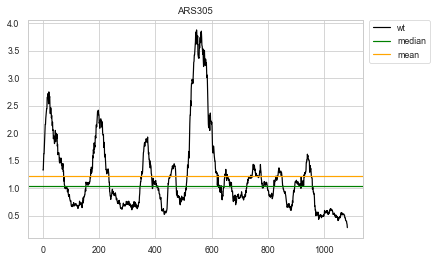

In [37]:

N=30
pooled_wt_smoothed = np.convolve(pooled_wt, np.ones(N)/N, mode="same")

sns.lineplot(x = range(pooled_wt_smoothed.shape[0]),
             y = pooled_wt_smoothed, color = "black", label = "wt")
plt.axhline(np.median(pooled_wt_smoothed,axis=0), color ="green", label = "median")
plt.axhline(np.mean(pooled_wt_smoothed,axis=0), color ="orange", label = "mean")
plt.title(load_dir)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0,
          labels = ["wt", "median", "mean"])

In [38]:
from scipy import signal

x = pooled_wt_smoothed[480:700]
peaks, properties = signal.find_peaks(x, width=20, 
                               #rel_height=0.9,
                               #prominence = (None, 0.8), 
                               #height= np.mean(x)
                              )
properties

{'prominences': array([3.17905775]),
 'left_bases': array([8]),
 'right_bases': array([205]),
 'widths': array([64.68500373]),
 'width_heights': array([2.2895695]),
 'left_ips': array([42.74523988]),
 'right_ips': array([107.43024361])}

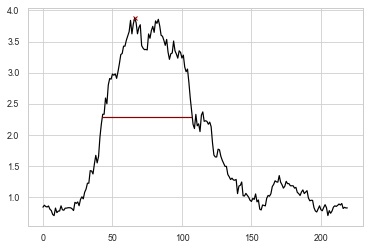

In [39]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "darkred")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
            xmax=properties["right_ips"], color = "darkred")

#plt.text(x = properties["left_ips"],y=properties["width_heights"], s = ("width: " + str(int(properties["widths"]))),
#         fontsize = 13, color="darkred")
plt.show()

In [40]:
signal.peak_widths(x, peaks, rel_height = 0.9)[0]

array([114.78016229])

Text(0.5, 1.0, 'Measure peak width at 90% rel height, ARS305')

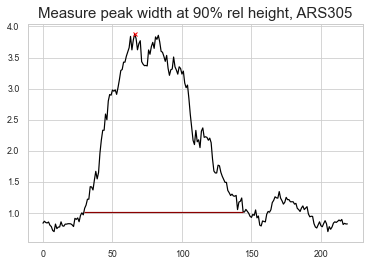

In [41]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "red")
plt.hlines(*signal.peak_widths(x, peaks, rel_height = 0.9)[1:], color ="darkred")
plt.title( "Measure peak width at 90% rel height, ARS305", fontsize = 15)

In [42]:
pooled_dies6_smoothed = np.convolve(pooled_dies6, np.ones(N)/N, mode = "same")[480:700]
pooled_disw2_smoothed = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[480:700]

Text(0.5, 1.0, 'Measure peak width at 90% rel height, ARS305')

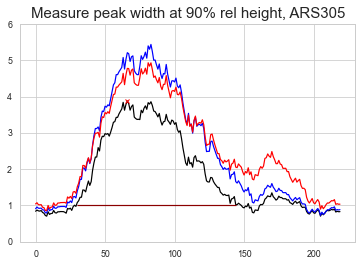

In [43]:
plt.plot(x, color = "black")
plt.plot(pooled_dies6_smoothed, color = "blue")
plt.plot(pooled_disw2_smoothed, color = "red")

plt.plot(peaks, x[peaks], "x", color = "red")
plt.hlines(*signal.peak_widths(x, peaks, rel_height = 0.9)[1:], color ="darkred")
plt.ylim(0, 6)
plt.title( "Measure peak width at 90% rel height, ARS305", fontsize = 15)

### Define the width of the nucleosome-free region as P10 - the peak width at 10% of peak height, from the wild type sample. This represents the cutoff for this origin for "nucleosome free"

In [44]:
width = signal.peak_widths(x, peaks, rel_height = 0.9)

In [45]:
peak_indices_dies6 = np.where(pooled_dies6_smoothed > width[1])[0]
width_dies6 = peak_indices_dies6[-1] - peak_indices_dies6[0]
print("peak width for dies6: ", width_dies6)

peak width for dies6:  171


In [46]:
#print(pooled_disw2_smoothed > width[1])
peak_indices_disw2 = np.where(pooled_disw2_smoothed > width[1])[0]
#width_disw2 = peak_indices_disw2[-1] - peak_indices_disw2[0]
width_disw2 = 204 - 16 #just measure the length of the largest stretch of Trues from the first line of this cell
print("peak width for disw2: ", width_disw2)

peak width for disw2:  188


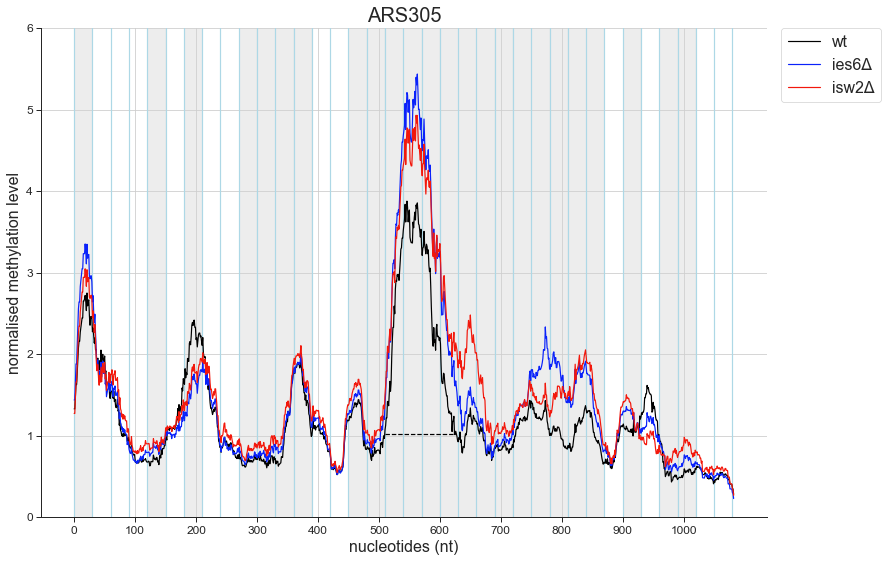

In [47]:
sns.set_context("paper")
#sns.set(style = "whitegrid", font_scale=1.5)
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        for left_border in saved.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        for feature in significant.index:
            plt.fill_betweenx(range(0,7), 
                      significant.loc[feature, "pos_start"],
                      significant.loc[feature, "pos_stop"], 
                      color = "lightgray", alpha = 0.4)
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir , fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize = 16)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100), fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.xlabel("nucleotides (nt)", fontsize = 16)
        plt.ylabel("normalised methylation level", fontsize = 16)
        
        plt.hlines(y=width[1], # properties["width_heights"],
                   xmin = width[2]+480,
                   xmax = width[3]+480, 
                   color = "black", linestyles = "dashed")
        
        #plt.savefig(load_dir + "/plots/ARS305_smoothed_profiles_revision_window30_union_selection_peak_width.svg", dpi=300, bbox_inches = "tight")
        plt.show()

## Find valleys in normalised single-molecule data around the origin as footprints of Mcm double hexamers

In [48]:
# Concatenate normalised data from replicates 
wt_norm = np.concatenate((wt_rep3_maxnorm, wt_rep2_maxnorm), axis = 0)
dies6_norm = np.concatenate((dies6_rep1_maxnorm, dies6_rep2_maxnorm), axis =0)
disw2_norm = np.concatenate((disw2_rep1_maxnorm, disw2_rep2_maxnorm), axis =0)

In [49]:
def measure_valleys(array2D, width_range:tuple = (50,70)):
    #define dataframe to store peak information in 
    peak_sums = pd.DataFrame({"left_bases" : None,
                            "widths" : None} , 
                            index = range(array2D.shape[0]))
    
    for index, row in enumerate(array2D):
        _, peak_array = signal.find_peaks(-row, width= width_range) # only store peaks between 45 and 70 bases
        peak_sums.loc[index, "left_bases"] = list(peak_array["left_bases"])
        peak_sums.loc[index, "widths"] = list(peak_array["widths"])
    return peak_sums

In [50]:
def restore_valleys(peak_summary_df, output_shape:tuple):
    # define array of zeros in output shape, et regions of peaks to one
    zeros_array = np.zeros(output_shape)
    # loop over peak summary dataframe
    for row_num in range(peak_summary_df.shape[0]):
        #check if there are detected peaks for this molecule
        if peak_summary_df.loc[row_num, "widths"]:
            left_pos = peak_summary_df.loc[row_num, "left_bases"]
            widths = peak_summary_df.loc[row_num, "widths"]
            for ind, _ in enumerate(left_pos):
                zeros_array[row_num, left_pos[ind]: (left_pos[ind] + int(widths[ind]))] = 1
                #set stretches for peak width to 1
    return zeros_array

In [51]:
width_range = (140,160)
peaks_wt = measure_valleys(wt_norm, width_range = width_range) #[:, 340:640]
rebuild_wt = restore_valleys(peaks_wt, wt_norm.shape) #[:, 340:640]

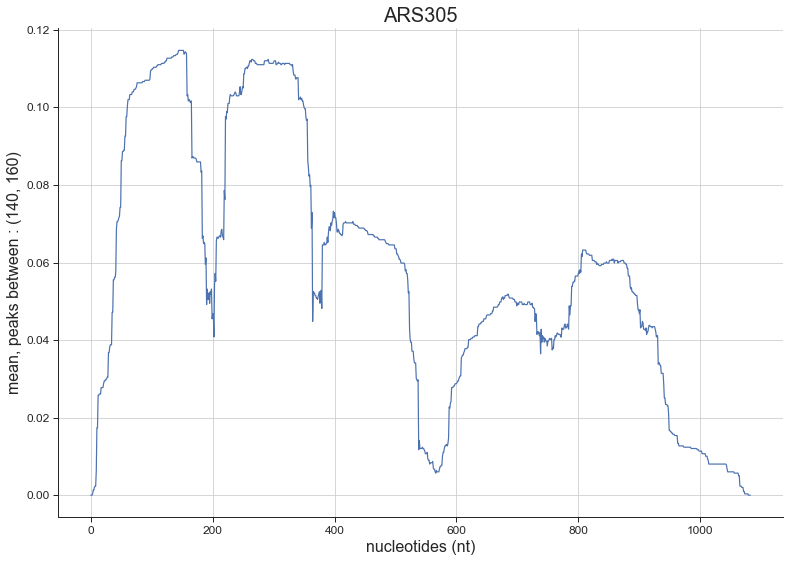

In [52]:
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.title(load_dir , fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 16)
        plt.plot(rebuild_wt.mean(axis=0))
        plt.show()

In [53]:
peaks_dies6 = measure_valleys(dies6_norm, width_range = width_range) #[:, 340:640]
rebuild_dies6 = restore_valleys(peaks_dies6, dies6_norm.shape) #[:, 340:640]

peaks_disw2 = measure_valleys(disw2_norm, width_range = width_range) #[:, 340:640]
rebuild_disw2 = restore_valleys(peaks_disw2, disw2_norm.shape) #[:, 340:640]

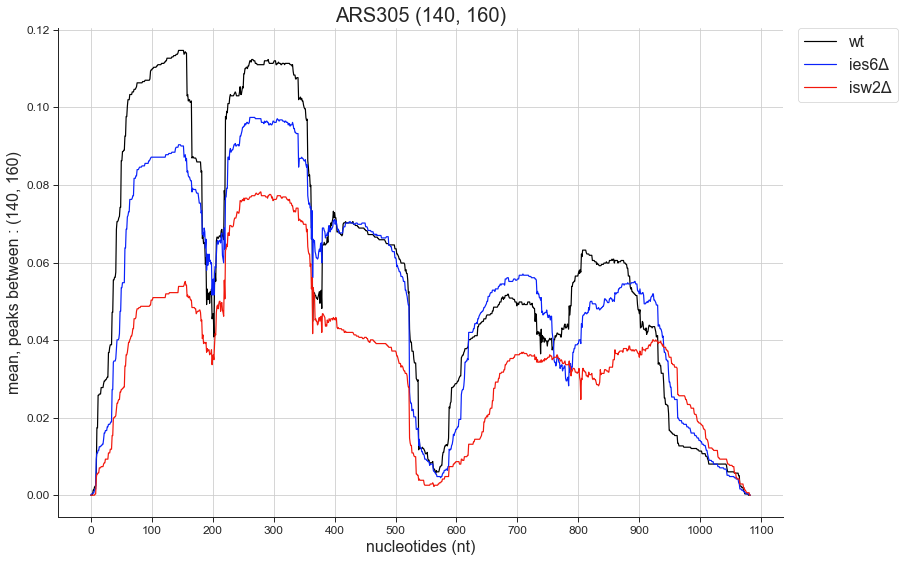

In [54]:
sns.set_context("paper")
#sns.set(style = "whitegrid", font_scale=1.5)
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        sns.lineplot(#x = range(340,640),
            x = range(wt_norm.shape[1]),
             y = rebuild_wt.mean(axis=0),
             color = "black", 
            label = "wt")
        sns.lineplot(#x = range(340,640),
            x = range(wt_norm.shape[1]),
             y = rebuild_dies6.mean(axis=0), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(#x = range(340,640),
            x = range(wt_norm.shape[1]),
            y = rebuild_disw2.mean(axis=0), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.xticks(range(0, 1200, 100), fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.title(load_dir +" " + str(width_range), fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 16)
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize = 16)
        
        #plt.savefig(load_dir + "/plots/ARS305_distribution_peaks_50_60.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

## Incorporate cluster information when detecting footprints of Mcm hexamers and nucleosomes

In [75]:
#read in a file that contains cluster labels for the positive DNA strands
cluster_info_df = pd.read_csv("ARS305/ARS305_postive_strands_feature_meth_window30_clusters.csv")

#construct an array from the normalised data and add information about molecule, replicate number and strand
all_data= pd.DataFrame()

for (array, name) in zip([wt_rep3_maxnorm, wt_rep2_maxnorm, 
                                  dies6_rep1_maxnorm, dies6_rep2_maxnorm,
                                  disw2_rep1_maxnorm, disw2_rep2_maxnorm],
                ["wt rep3", "wt rep2", "dies6 rep1", "dies6 rep2", "disw2 rep1", "disw2 rep2"]):
    inter = pd.DataFrame(array)
    inter["molecule"] = inter.index
    inter["replicate"] = name
    inter["strand"] = ["plus" if i<inter.shape[0]//2 else "minus" for i in range(inter.shape[0])]
    all_data = pd.concat([all_data, inter], axis = 0)

#filter for positive strands, add cluster information    
all_data_plus = all_data.loc[all_data.strand == "plus"].merge(cluster_info_df.loc[:, ["replicate", "molecule", "cluster"]], 
                on = ["replicate", "molecule"], how = "inner")
all_data_plus.head()

,0,1,2,3,4,5,6,7,8,9,...,1077,1078,1079,1080,1081,1082,molecule,replicate,strand,cluster
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,20.711223,0.0,0.0,0.0,0.0,0.0,0,wt rep3,plus,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,20.711223,0.0,0.0,0.0,0.0,0.0,1,wt rep3,plus,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.711223,...,0.000000,0.0,0.0,0.0,0.0,0.0,2,wt rep3,plus,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,3,wt rep3,plus,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,4,wt rep3,plus,3


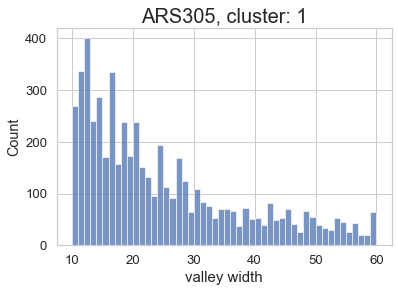

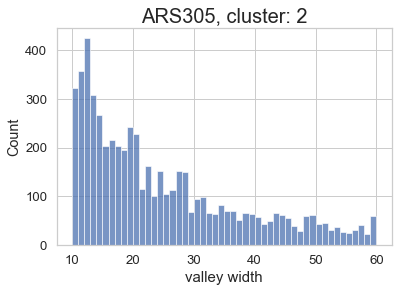

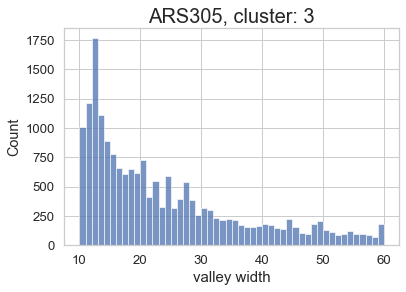

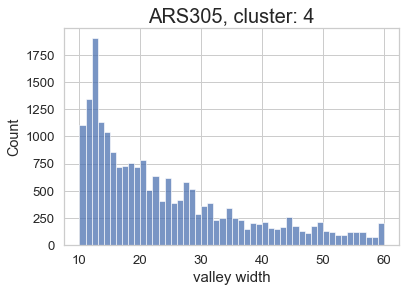

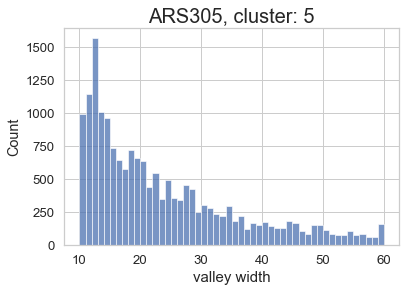

In [76]:
# this plot shows a histogram of valleys (=occupied DNA) in the range of some nucleotides (set width range for that)
width_range = (10, 60)

for cluster in set(all_data_plus.cluster):
    
    data_temp = np.array(all_data_plus.loc[all_data_plus.cluster == cluster, :1082])
    
    peaks_temp = measure_valleys(data_temp, width_range = width_range)
    rebuild_temp = restore_valleys(peaks_temp, data_temp.shape)

    listofpeakwidths = []

    for row in peaks_temp.widths:
        listofpeakwidths = listofpeakwidths + row
    
    sns.histplot(listofpeakwidths, binwidth=1)
    plt.title(load_dir + ", cluster: " + str(cluster) , fontsize=20)
    plt.xlabel("valley width", fontsize=15)
    plt.show()

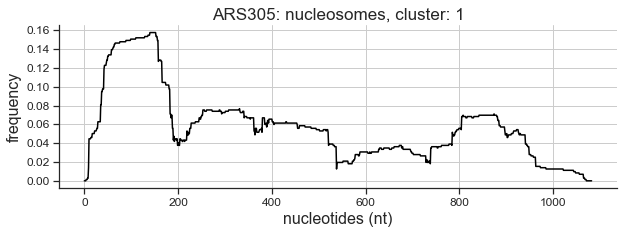

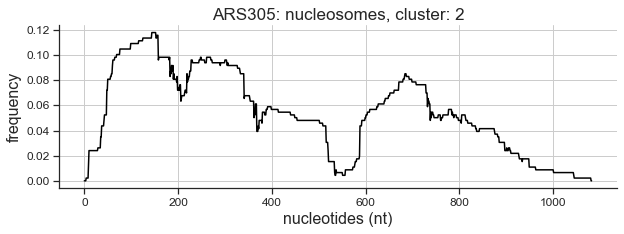

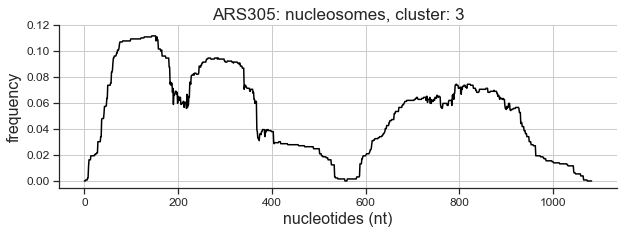

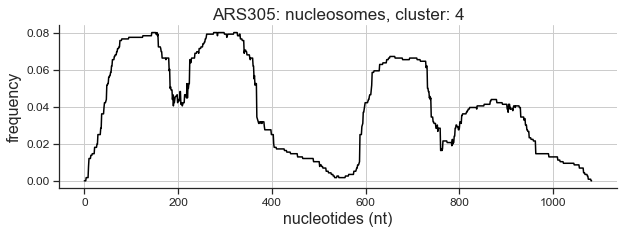

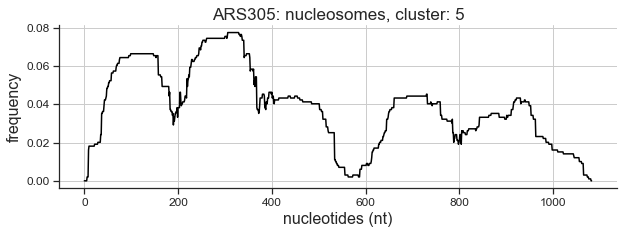

In [77]:
### This produces plots from Figure 9 in the MATACseq paper:

width_range = (140,160)

for cluster in set(all_data_plus.cluster):
    
    
    with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        data_temp = np.array(all_data_plus.loc[all_data_plus.cluster == cluster, :1082])
    
        peaks_temp = measure_valleys(data_temp, width_range = width_range)
        rebuild_temp = restore_valleys(peaks_temp, data_temp.shape)
    
        plt.figure(figsize = (10,3))
        plt.plot(rebuild_temp.mean(axis=0), color = "black")
        #plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 15)
        plt.title(load_dir + ": nucleosomes, cluster: " + str(cluster) , fontsize=17)#+", size: 57-59 nt"
        
        plt.xticks(fontsize=12)
        #plt.yticks(fontsize=12)
        plt.yticks(np.arange(0, rebuild_temp.mean(axis=0).max() + 0.015, 0.02), fontsize=12)
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("frequency", fontsize = 16)
        
        #plt.savefig(load_dir + "/plots/ARS315_footprint_nucleosomes_" + str(cluster) + ".pdf")
        #plt.ylim((0, 0.2))
        plt.show()  

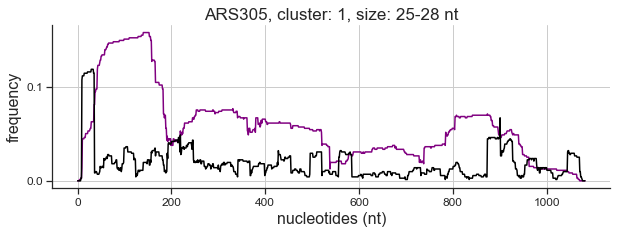

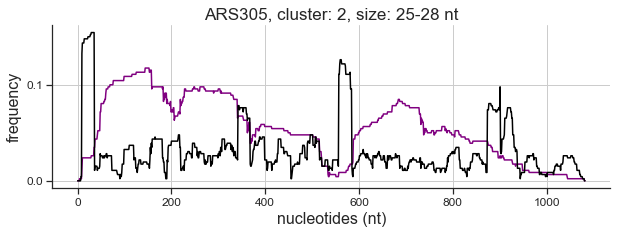

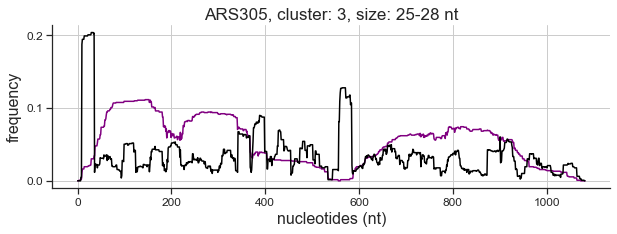

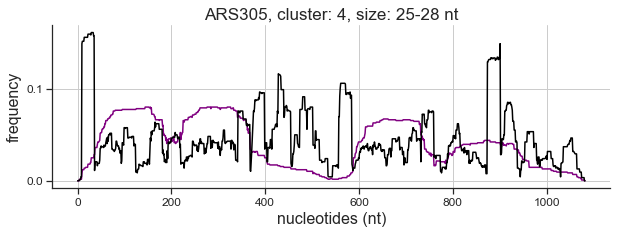

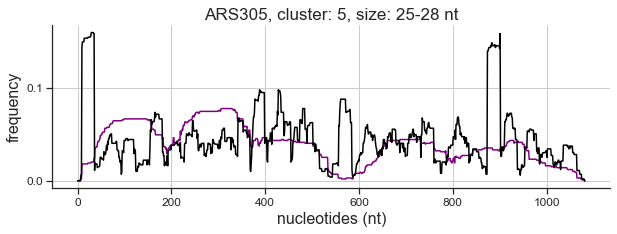

In [78]:
# Plot smaller valleys and nucleosomes together:

width_range = (25,29)

for cluster in set(all_data_plus.cluster):
    
    
    with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        data_temp = np.array(all_data_plus.loc[all_data_plus.cluster == cluster, :1082])
    
        peaks_temp = measure_valleys(data_temp, width_range = width_range)
        rebuild_temp = restore_valleys(peaks_temp, data_temp.shape)
        
        peaks_nuc = measure_valleys(data_temp, width_range = (140,160))
        rebuild_nuc = restore_valleys(peaks_nuc, data_temp.shape)
    
        plt.figure(figsize = (10,3))
        
        plt.plot(rebuild_nuc.mean(axis=0), color = "purple")
        
        plt.plot(rebuild_temp.mean(axis=0), color = "black")
        plt.title(load_dir + ", cluster: " + str(cluster) +", size: 25-28 nt", fontsize=17) #
        
        plt.xticks(fontsize=12)
        plt.yticks(np.arange(0, rebuild_temp.mean(axis=0).max() + 0.005, 0.1), fontsize=12)
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("frequency", fontsize = 16)

        #plt.ylim((0, 0.30))
        plt.show() 

In [79]:
#  Cluster sizes:
all_data_plus.cluster.value_counts()

3    1289
4    1159
5     992
1     717
2     458
Name: cluster, dtype: int64

## Plot the per base efficiency for the whole ARS305 origin:

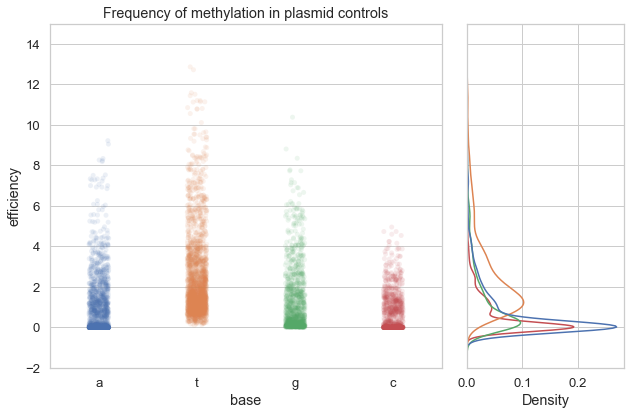

In [80]:
#prepare the data:
seq = "atgaaagaatacgttattctttcatcaaatcgtggtcgaccggcatgcaagctccctcgagAAATACAGAATAGGAAAGTAAAAGGCAATATATGAATGCAGTGCTTGTAACTGGTGCTTGTATCCAAGAATAGCTTCTTGCTGTAGGTTATGGGAATATCGTGTAAGCTGGGGTGACTTTTGAGCTATTCGCGACGCCCGACGCCGTAATAACTACTTTCGACAGACCACTTATGACAGTATTTCAGGCCGCTCTTATAAAATGACATGTTAACAAACAGTTCTGATTATTCGCCTTTTGACAGGACGATAATGTAAATAGTTGTGGTAGTATCATTCAGGTATGTAACTGTTTACTTTGTATCGCTTGAAAAAAATAAGCATTTCAGAGCCTTCTTTGGAGCTCAAGTGGATTGAGGCCACAGCAAGACCGGCCAGTTTGAATGCTCAACTCTTCAAAAGAAATTCCTCAAATATGTCCAGTTTCATGTACTGTCCGGTGTGATTTATTATTTTTTATTTACTTTGTAGTTCTTAAAGCTAAGATTTTTTTCTTTGATAAATTCTTGTTTTCATATCCTAAAATTAAAGGGAAAATAAACAATACATAACAAAACATATAAAAACCAACACAATAAAAAAAAGGATCAAATACTCATTAAAGTAACTTACACGGGGGCTAAAAACGGAGTTTGATGAATATTCACAAGATAAAAATCATATGTATGTTTCTGATATATCGATATACAATCAAACACTTTCAAGAATTTGTTTGTAGACTTTTTGCTAGAGACCTCATCAAAGTGCTACCAACTAAGATCAACTTATACTTCTTTTAGAGAAAATTTTTTTCAATGTACTCCAAAGAGATTTAGATCCTGTCTCTTCCTCTTCCTCTTCCTCGAAAGTCAAAGAAAAATCAGAGTCTCCCTGCTTATTCAGGCGGAGAGGCTCTAGGGTAGTTGCGTTTCTCTCATTGGGACACTGAACCTCATTTTCCAACATTTTGGTCATGTAAGAGGCGACAGGCTCATCGCAGGTGGGTGCATCAACATGGTAGTACCTGGACCAAGCGCTACATTG"
seq=seq.lower()

eff_df = pd.DataFrame({"wt_rep3": wt_rep3_maxnorm.mean(axis=0)}, index=range(1083)) 

eff_df["base"] = [letter for letter in seq]

eff_df["wt_rep2"] = wt_rep2_maxnorm.mean(axis=0)
eff_df["dies6_rep1"] = dies6_rep1_maxnorm.mean(axis=0)
eff_df["dies6_rep2"] = dies6_rep2_maxnorm.mean(axis=0)
eff_df["disw2_rep1"] = disw2_rep1_maxnorm.mean(axis=0)
eff_df["disw2_rep2"] = disw2_rep1_maxnorm.mean(axis=0)

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.1, ax= axs[0])
axs[0].set_title("Frequency of methylation in plasmid controls")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid.tif", dpi=300)

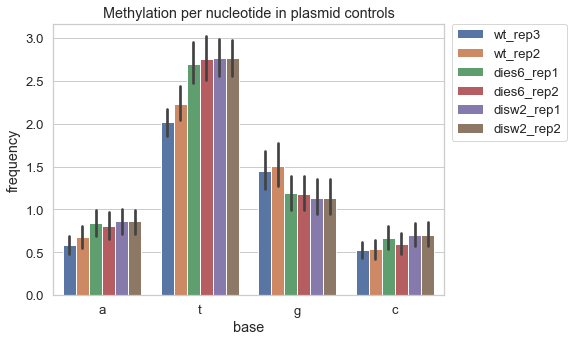

In [81]:
plt.figure(figsize=(7,5))
sns.barplot(data=eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Methylation per nucleotide in plasmid controls")
plt.ylabel("frequency")
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid_per_sample.tif", dpi=300, bbox_inches='tight')
plt.show()

<AxesSubplot:title={'center':'Normalized methylation over samples'}, xlabel='sample', ylabel='normalized frequency of methylation'>

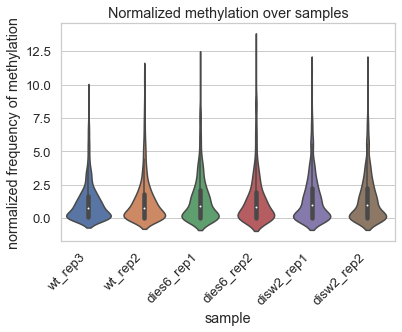

In [82]:
g = sns.violinplot(data = eff_df_melt, x = "sample", y = "efficiency", alpha=0.1)
g.set_ylabel("normalized frequency of methylation")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Normalized methylation over samples")

g